In [ ]:
# Set up Mosaic runtime for distributed computing

import mosaic

await mosaic.interactive('on', num_workers=4, log_level='info')

runtime = mosaic.runtime()

Listening at <CommsManager object at 140406160607952, uid=monitor, address=sonus-2.us-central1-f.c.project-sonus.internal, port=3012, state=connected>HEAD            Listening at <CommsManager object at 140406160326160, uid=head, address=sonus-2.us-central1-f.c.project-sonus.internal, port=3016, state=connected>


MONITOR         Listening at <NODE:0 | WORKER:0-4>


Model data shape: (480, 480, 350)
Data range: min=343.0, max=2800.0
Data type: float64


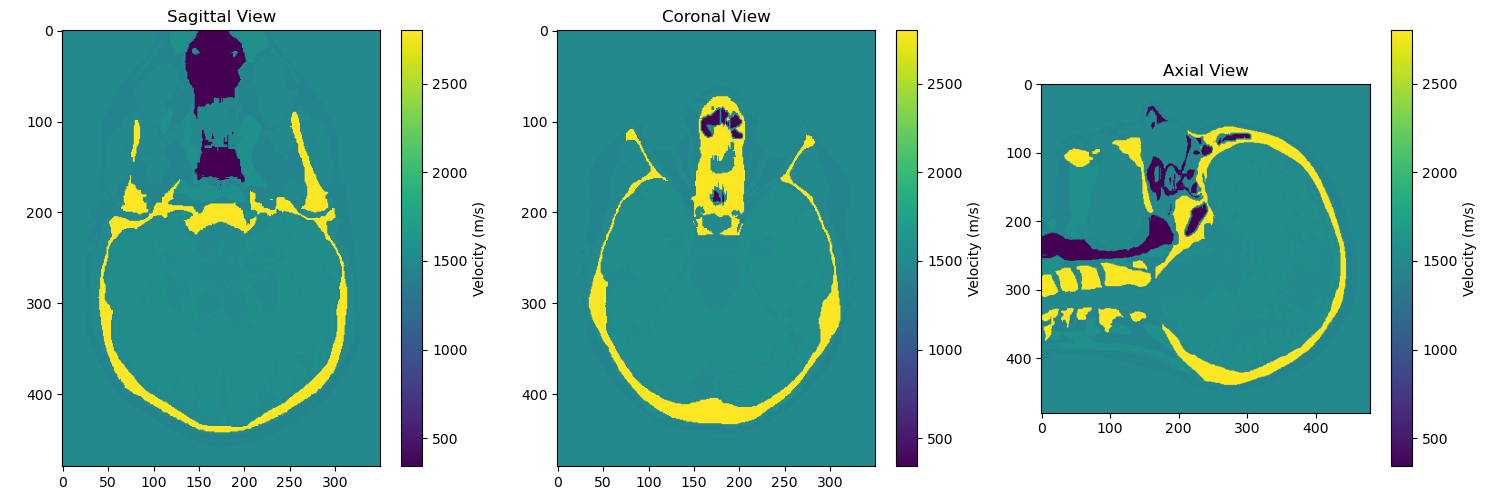


Problem configuration:
Space shape: (480, 480, 350)
Spatial resolution: 0.5 mm
Number of transducers: 1024
Center frequency: 0.4 MHz
Time samples: 3000
Total simulation time: 240.0 μs


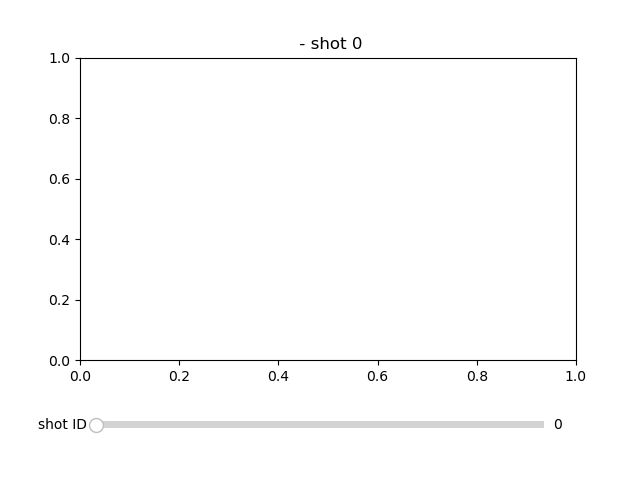

In [46]:
from stride.utils import fetch, wavelets
from stride import Space, Time, Grid
from stride import Problem, ScalarField
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib widget

# Load the MIDA model
with h5py.File('/home/leozaroff/mida_model.h5', 'r') as f:
    vp_data = np.array(f['vp'])
    print(f"Model data shape: {vp_data.shape}")
    print(f"Data range: min={np.min(vp_data)}, max={np.max(vp_data)}")
    print(f"Data type: {vp_data.dtype}")

# Paper settings:
# - Sub-MHz frequencies (100-850 kHz)
# - 500μm isotropic resolution
# - 1024 transducers around the head
spacing = (0.5e-3, 0.5e-3, 0.5e-3)  # 500μm spacing as per paper
space = Space(shape=vp_data.shape, 
             extra=(50, 50, 50),     # Extra space for wave propagation
             absorbing=(40, 40, 40),  # Absorbing boundary conditions
             spacing=spacing)

# Time settings based on paper's sub-MHz frequency requirements
dt = 0.08e-6  # Time step
T = 240e-6    # Total time (240 μs as per paper)
nt = int(T/dt)
time = Time(start=0, step=dt, num=nt)

grid = Grid(space, time)

# Create problem
problem = Problem(name='head3D', space=space, time=time)

# Create transducers - paper uses 1024 transducers
num_locations = 1024  # As specified in paper
problem.transducers.default()

# Set up geometry for transducer placement
# Paper places transducers around the head in 3D, avoiding face
radius = ((space.limit[0] - 30e-3) / 2,
         (space.limit[1] - 30e-3) / 2,
         (space.limit[2] - 30e-3) / 2)
centre = (space.limit[0] / 2,
         space.limit[1] / 2,
         space.limit[2] / 2)

# Create ellipsoidal arrangement avoiding the face area
problem.geometry.default('ellipsoidal', num_locations, radius, centre,
                       theta=np.pi * 0.75,  # Reduced angle to avoid face
                       threshold=0.5)

# Setup acquisitions
problem.acquisitions.default()

# Create wavelets - paper uses 100-850 kHz bandwidth
f_centre = 0.4e6  # 400 kHz center frequency
n_cycles = 3      # 3-cycle tone burst as mentioned in paper

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

# Load velocity model
vp_true = ScalarField(name='vp', grid=grid, data=vp_data)
problem.medium.add(vp_true)

# Enhanced visualization
plt.figure(figsize=(15, 5))

# Plot three orthogonal slices
plt.subplot(131)
plt.imshow(vp_data[vp_data.shape[0]//2, :, :], cmap='viridis')
plt.title('Sagittal View')
plt.colorbar(label='Velocity (m/s)')

plt.subplot(132)
plt.imshow(vp_data[:, vp_data.shape[1]//2, :], cmap='viridis')
plt.title('Coronal View')
plt.colorbar(label='Velocity (m/s)')

plt.subplot(133)
plt.imshow(vp_data[:, :, vp_data.shape[2]//2], cmap='viridis')
plt.title('Axial View')
plt.colorbar(label='Velocity (m/s)')

plt.tight_layout()
plt.show()

# Print configuration details
print("\nProblem configuration:")
print(f"Space shape: {space.shape}")
print(f"Spatial resolution: {spacing[0]*1e3} mm")
print(f"Number of transducers: {num_locations}")
print(f"Center frequency: {f_centre/1e6} MHz")
print(f"Time samples: {time.num}")
print(f"Total simulation time: {T*1e6} μs")

# Try problem visualization
try:
    problem.plot()
except Exception as e:
    print(f"\nError in problem visualization: {e}")
    print("Attempting alternative visualization...")
    try:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot transducer positions
        positions = problem.geometry.coordinates
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                  c='red', marker='o', label='Transducers')
        
        # Add a semi-transparent volume to show head boundaries
        x, y, z = np.meshgrid(np.linspace(0, space.limit[0], 10),
                             np.linspace(0, space.limit[1], 10),
                             np.linspace(0, space.limit[2], 10))
        ax.scatter(x, y, z, alpha=0.1)
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.legend()
        plt.show()
    except Exception as e:
        print(f"Alternative visualization failed: {e}")

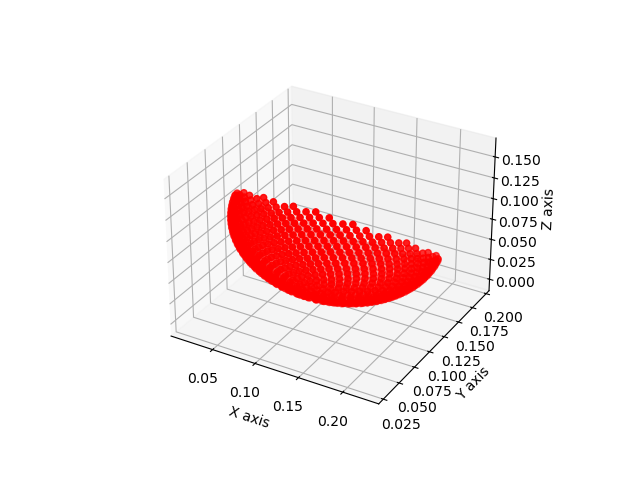

In [5]:
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  coords = problem.geometry.coordinates
  ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', marker='o')
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')
  plt.show()


In [5]:
from stride import IsoAcousticDevito

# Set up PDE solver for wave propagation
pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

In [11]:
from stride import forward

# Run default forward workflow
await forward(problem, pde, vp_true, dump=False)

MemoryOverflowError: Not enough memory to allocate 843659745 bytes for task <Task object at 4951990096, uid=task-isoacousticdevito-__call__-d75ad273c71c4644baaa561127db703a, runtime=worker:0:0, state=pending>

Starting model: 

Unlike in the forward problem, the speed of sound field is unknown to us at this point. We need to choose a starting assumption to begin optimizing from. Here we assume a homogenous speed of 1500 m/s (~water's speed of sound).

In [ ]:
# Initialize starting model for inversion
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.) # Initialize with a constant velocity

problem.medium.add(vp)

Imaging operators:

Define operators for our loss function, processing our source wavelets and the modelled/observed data traces, and an optimizer to update the speed of sound model after each iteration (here we use gradient descent).

We also limited the speed of sound to between 1400 and 1700 m/s, which will need to change when we introduce bone.

In [ ]:
from stride import L2DistanceLoss 

# Set up optimization components
loss = L2DistanceLoss.remote(len=runtime.num_workers)

from stride import ProcessWavelets, ProcessObserved, ProcessWaveletsObserved, ProcessTraces


process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_observed = ProcessObserved.remote(len=runtime.num_workers)
process_wavelets_observed = ProcessWaveletsObserved.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

# Configure optimization parameters
step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

Inverse problem -- estimating the speed of sound:

We use a multi-frequency approach, starting with lower frequencies and then moving to higher frequencies for more detail. This is done by dividing the optimization into blocks, each with a max frequency.

During each iteration, only a random subset of the shots will actually be used. 

Here we use the utility function "adjoint" to run this optimization loop. If you want to see more detailed code, take a look at the 2d example notebook.

In [ ]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
# Run multi-frequency inversion

max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
    await adjoint(problem, pde, loss,
        optimisation_loop, optimiser, vp,
        num_iters=num_iters,
        select_shots=dict(num=15, randomly=True),
        f_max=freq)

vp.plot()

Tear down the mosaic runtime:

In [ ]:
await mosaic.interactive('off')